In [1]:
# ВНИМАНИЕ; версия Pillow установвленна по умолчанию - '7.0.0'
# Эта версия ломает torchvision
import PIL
PIL.__version__

'7.1.2'

# Путешествие по Спрингфилду.


Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.1+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.1+cu101)


In [ ]:
# ИСПРАВЛЕНИЕ: к сожалению этот код не работает у меня на коллабе
# плюс что-то намудрено с именами в репозитории pytorch
  
# установка подходящей версии torch

#from os.path import exists
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.5.0%2B{platform}-linux_x86_64.whl torchvision
#import torch

ERROR: torch-1.5.0+cp36-cp36m-linux_x86_64.whl is not a valid wheel filename.


In [2]:
# ИСПРАВЛЕНИЕ:
# Вручную ищем и устанавливаем подходящуюю версию 
# https://download.pytorch.org/whl/torch_stable.html 
!pip install -q 'https://download.pytorch.org/whl/cu101/torch-1.5.0%2Bcu101-cp36-cp36m-linux_x86_64.whl' torchvision
import torch

ERROR: torch-1.5.0+cu101-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.


In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# ВНИМАНИЕ: мы это уже сделали вначале ноутбука

# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
#!pip uninstall -y Pillow
#!pip install Pillow==5.3.0
#import PIL
#print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/




---

**ВНИМАНИЕ: скачайте датасет с каггла и положите его в корень своего гугл диска!**

---



In [3]:
# ИСПРАВЛЕНИЕ
#!unzip -q /content/gdrive/My\ Drive/simpsons/data/dataset.zip -d train
#!unzip -q /content/gdrive/My\ Drive/simpsons/data/testset.zip -d test

!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

In [4]:
!ls train

simpsons_dataset


In [5]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Apr 25 16:07:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    33W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картинок, для которых вам будет необходимо предсказать класс.

In [6]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [7]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} \\$,      константы - средние и дисперсии по каналам на основе ImageNet

Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [8]:
class SimpsonsDataset(Dataset):
    """
    Сделаем аугментацию данных, чтобы улучшить наш датасет!
    """
    data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [11]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [12]:
#классы несбалансированы, придется делать оверсамплинг!
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [13]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [14]:
# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [15]:
# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [16]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train


In [17]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(new_train_files, mode='train')

In [19]:
# определим загрузщики данных без взвешивания классов для их балансировки простой вариант
BATCH_SIZE = 32
# DataLoader достаёт данные из dataset батчами
dataloaders = {'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset) }

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

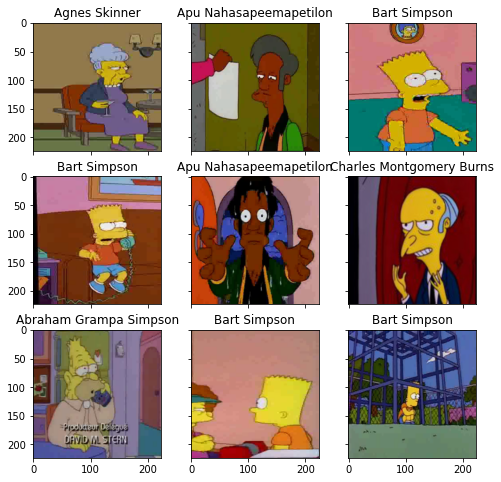

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети


*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [41]:
# Не очень простая сеть
# Будем использовать батчнорм, авпулинг и 4 полносвязных слоя
class Cnn(nn.Module):
    def __init__(self, n_classes=42):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(4 * 4 * 256, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU()
        )

        self.fc3 = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU()
        )

        self.fc4 = nn.Sequential(
            nn.Linear(2048, n_classes),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)

        x = torch.nn.functional.interpolate(x, size=(4, 4), align_corners=False, mode='bilinear')
        x = x.view(x.size(0), 4 * 4 * 256)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x

In [42]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [43]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [44]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [45]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [46]:
n_classes = len(np.unique(train_val_labels))
cnn = Cnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(cnn)

we will classify :42
Cnn(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=3, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=3, stride=2, padding=0)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, af

Запустим обучение сети.

In [47]:
history = train(train_dataset, val_dataset, model = cnn, epochs = 50, batch_size = 16)

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss 2.9672471474034787


epoch:   2%|▏         | 1/50 [03:50<3:08:00, 230.21s/it]


Epoch 001 train_loss: 2.9672     val_loss 2.2416 train_acc 0.2328 val_acc 0.3838
loss 2.0133990769486485


epoch:   4%|▍         | 2/50 [07:39<3:04:02, 230.06s/it]


Epoch 002 train_loss: 2.0134     val_loss 1.6952 train_acc 0.4437 val_acc 0.5296
loss 1.470960726840992


epoch:   6%|▌         | 3/50 [11:21<2:58:09, 227.43s/it]


Epoch 003 train_loss: 1.4710     val_loss 1.3114 train_acc 0.5869 val_acc 0.6334
loss 1.0830232263493376


epoch:   8%|▊         | 4/50 [14:59<2:52:14, 224.65s/it]


Epoch 004 train_loss: 1.0830     val_loss 1.0865 train_acc 0.6922 val_acc 0.6956
loss 0.8137445909185288


epoch:  10%|█         | 5/50 [18:37<2:46:59, 222.67s/it]


Epoch 005 train_loss: 0.8137     val_loss 1.0998 train_acc 0.7657 val_acc 0.7084
loss 0.6246076401529245


epoch:  12%|█▏        | 6/50 [22:13<2:41:56, 220.83s/it]


Epoch 006 train_loss: 0.6246     val_loss 0.8218 train_acc 0.8178 val_acc 0.7822
loss 0.4730761772581161


epoch:  14%|█▍        | 7/50 [25:50<2:37:24, 219.65s/it]


Epoch 007 train_loss: 0.4731     val_loss 0.8492 train_acc 0.8622 val_acc 0.7820
loss 0.358354631866284


epoch:  16%|█▌        | 8/50 [29:26<2:32:57, 218.51s/it]


Epoch 008 train_loss: 0.3584     val_loss 0.7744 train_acc 0.8951 val_acc 0.8168
loss 0.2780449973703749


epoch:  18%|█▊        | 9/50 [33:01<2:28:34, 217.43s/it]


Epoch 009 train_loss: 0.2780     val_loss 0.8156 train_acc 0.9165 val_acc 0.8181
loss 0.21823033904353584


epoch:  20%|██        | 10/50 [36:37<2:24:39, 216.98s/it]


Epoch 010 train_loss: 0.2182     val_loss 0.9461 train_acc 0.9349 val_acc 0.7950
loss 0.18062140440612978


epoch:  22%|██▏       | 11/50 [40:13<2:20:51, 216.71s/it]


Epoch 011 train_loss: 0.1806     val_loss 0.8468 train_acc 0.9464 val_acc 0.8265
loss 0.14101707689855061


epoch:  24%|██▍       | 12/50 [43:49<2:17:00, 216.33s/it]


Epoch 012 train_loss: 0.1410     val_loss 1.0596 train_acc 0.9594 val_acc 0.8013
loss 0.12941676023266077


epoch:  26%|██▌       | 13/50 [47:24<2:13:13, 216.03s/it]


Epoch 013 train_loss: 0.1294     val_loss 0.8671 train_acc 0.9637 val_acc 0.8284
loss 0.11512545295869903


epoch:  28%|██▊       | 14/50 [51:09<2:11:12, 218.68s/it]


Epoch 014 train_loss: 0.1151     val_loss 0.9882 train_acc 0.9685 val_acc 0.8131
loss 0.11387689339981351


epoch:  30%|███       | 15/50 [55:00<2:09:42, 222.37s/it]


Epoch 015 train_loss: 0.1139     val_loss 1.1529 train_acc 0.9664 val_acc 0.7998
loss 0.09942942633918264


epoch:  32%|███▏      | 16/50 [58:47<2:06:55, 223.98s/it]


Epoch 016 train_loss: 0.0994     val_loss 1.0397 train_acc 0.9720 val_acc 0.8202
loss 0.09599339831502239


epoch:  34%|███▍      | 17/50 [1:02:35<2:03:42, 224.93s/it]


Epoch 017 train_loss: 0.0960     val_loss 0.9562 train_acc 0.9741 val_acc 0.8261
loss 0.0951109636596861


epoch:  36%|███▌      | 18/50 [1:06:22<2:00:21, 225.68s/it]


Epoch 018 train_loss: 0.0951     val_loss 0.9683 train_acc 0.9747 val_acc 0.8380
loss 0.08029770640286944


epoch:  38%|███▊      | 19/50 [1:10:11<1:57:02, 226.55s/it]


Epoch 019 train_loss: 0.0803     val_loss 1.0006 train_acc 0.9777 val_acc 0.8296
loss 0.09158820503204386


epoch:  40%|████      | 20/50 [1:13:59<1:53:32, 227.08s/it]


Epoch 020 train_loss: 0.0916     val_loss 1.0630 train_acc 0.9744 val_acc 0.8181
loss 0.0733470717613066


epoch:  42%|████▏     | 21/50 [1:17:47<1:49:57, 227.50s/it]


Epoch 021 train_loss: 0.0733     val_loss 1.0833 train_acc 0.9808 val_acc 0.8265
loss 0.0870406791898992


epoch:  44%|████▍     | 22/50 [1:21:37<1:46:26, 228.08s/it]


Epoch 022 train_loss: 0.0870     val_loss 0.9891 train_acc 0.9773 val_acc 0.8227
loss 0.055323906493497534


epoch:  46%|████▌     | 23/50 [1:25:27<1:42:51, 228.57s/it]


Epoch 023 train_loss: 0.0553     val_loss 1.0195 train_acc 0.9845 val_acc 0.8449
loss 0.057110785526711436


epoch:  48%|████▊     | 24/50 [1:29:14<1:38:50, 228.10s/it]


Epoch 024 train_loss: 0.0571     val_loss 1.1066 train_acc 0.9850 val_acc 0.8433
loss 0.08520783589678477


epoch:  50%|█████     | 25/50 [1:33:00<1:34:50, 227.62s/it]


Epoch 025 train_loss: 0.0852     val_loss 1.0943 train_acc 0.9787 val_acc 0.8319
loss 0.05885525823870997


epoch:  52%|█████▏    | 26/50 [1:36:47<1:31:00, 227.53s/it]


Epoch 026 train_loss: 0.0589     val_loss 0.9917 train_acc 0.9861 val_acc 0.8344
loss 0.05447342064421858


epoch:  54%|█████▍    | 27/50 [1:40:36<1:27:23, 228.00s/it]


Epoch 027 train_loss: 0.0545     val_loss 1.0855 train_acc 0.9852 val_acc 0.8470
loss 0.062139100197053175


epoch:  56%|█████▌    | 28/50 [1:44:26<1:23:44, 228.37s/it]


Epoch 028 train_loss: 0.0621     val_loss 0.9302 train_acc 0.9854 val_acc 0.8468
loss 0.06500350341571988


epoch:  58%|█████▊    | 29/50 [1:48:14<1:19:58, 228.48s/it]


Epoch 029 train_loss: 0.0650     val_loss 1.1061 train_acc 0.9848 val_acc 0.8277
loss 0.05463879406130544


epoch:  60%|██████    | 30/50 [1:52:05<1:16:20, 229.01s/it]


Epoch 030 train_loss: 0.0546     val_loss 1.0395 train_acc 0.9877 val_acc 0.8279
loss 0.05399043842062082


epoch:  62%|██████▏   | 31/50 [1:55:57<1:12:47, 229.87s/it]


Epoch 031 train_loss: 0.0540     val_loss 1.0235 train_acc 0.9871 val_acc 0.8376
loss 0.05580393165427717


epoch:  64%|██████▍   | 32/50 [1:59:47<1:08:58, 229.90s/it]


Epoch 032 train_loss: 0.0558     val_loss 1.1329 train_acc 0.9853 val_acc 0.8473
loss 0.050526941089148535


epoch:  66%|██████▌   | 33/50 [2:03:35<1:04:59, 229.38s/it]


Epoch 033 train_loss: 0.0505     val_loss 1.1051 train_acc 0.9863 val_acc 0.8451
loss 0.05539039019112806


epoch:  68%|██████▊   | 34/50 [2:07:23<1:01:05, 229.09s/it]


Epoch 034 train_loss: 0.0554     val_loss 1.1848 train_acc 0.9882 val_acc 0.8405
loss 0.06169059472486295


epoch:  70%|███████   | 35/50 [2:11:12<57:15, 229.00s/it]


Epoch 035 train_loss: 0.0617     val_loss 1.1525 train_acc 0.9859 val_acc 0.8456
loss 0.04391686867695291


epoch:  72%|███████▏  | 36/50 [2:15:00<53:20, 228.58s/it]


Epoch 036 train_loss: 0.0439     val_loss 1.0819 train_acc 0.9903 val_acc 0.8535
loss 0.04882450982124403


epoch:  74%|███████▍  | 37/50 [2:18:50<49:39, 229.21s/it]


Epoch 037 train_loss: 0.0488     val_loss 1.2790 train_acc 0.9885 val_acc 0.8181
loss 0.04782533391666006


epoch:  76%|███████▌  | 38/50 [2:22:42<45:58, 229.86s/it]


Epoch 038 train_loss: 0.0478     val_loss 1.1405 train_acc 0.9891 val_acc 0.8540
loss 0.045505542697109214


epoch:  78%|███████▊  | 39/50 [2:26:31<42:07, 229.79s/it]


Epoch 039 train_loss: 0.0455     val_loss 1.0214 train_acc 0.9895 val_acc 0.8345
loss 0.06560026869539716


epoch:  80%|████████  | 40/50 [2:30:20<38:14, 229.46s/it]


Epoch 040 train_loss: 0.0656     val_loss 1.1866 train_acc 0.9854 val_acc 0.8242
loss 0.04488072178706501


epoch:  82%|████████▏ | 41/50 [2:34:11<34:29, 229.93s/it]


Epoch 041 train_loss: 0.0449     val_loss 1.1227 train_acc 0.9902 val_acc 0.8298
loss 0.02598223873962352


epoch:  84%|████████▍ | 42/50 [2:38:03<30:44, 230.52s/it]


Epoch 042 train_loss: 0.0260     val_loss 1.2834 train_acc 0.9940 val_acc 0.8479
loss 0.04640525854058191


epoch:  86%|████████▌ | 43/50 [2:41:53<26:52, 230.32s/it]


Epoch 043 train_loss: 0.0464     val_loss 1.2788 train_acc 0.9886 val_acc 0.8374
loss 0.05142693536608077


epoch:  88%|████████▊ | 44/50 [2:45:40<22:56, 229.37s/it]


Epoch 044 train_loss: 0.0514     val_loss 1.2473 train_acc 0.9880 val_acc 0.8355
loss 0.03509900178390132


epoch:  90%|█████████ | 45/50 [2:49:28<19:05, 229.12s/it]


Epoch 045 train_loss: 0.0351     val_loss 1.2775 train_acc 0.9919 val_acc 0.8389
loss 0.05119409434931323


epoch:  92%|█████████▏| 46/50 [2:53:18<15:17, 229.29s/it]


Epoch 046 train_loss: 0.0512     val_loss 1.2847 train_acc 0.9893 val_acc 0.8296
loss 0.048856091591610785


epoch:  94%|█████████▍| 47/50 [2:57:06<11:26, 228.82s/it]


Epoch 047 train_loss: 0.0489     val_loss 1.0112 train_acc 0.9898 val_acc 0.8340
loss 0.04229215640642825


epoch:  96%|█████████▌| 48/50 [3:00:51<07:35, 227.89s/it]


Epoch 048 train_loss: 0.0423     val_loss 1.1422 train_acc 0.9907 val_acc 0.8267
loss 0.039958356530702614


epoch:  98%|█████████▊| 49/50 [3:04:37<03:47, 227.28s/it]


Epoch 049 train_loss: 0.0400     val_loss 1.2181 train_acc 0.9917 val_acc 0.8258
loss 0.05570446377615936


epoch: 100%|██████████| 50/50 [3:08:24<00:00, 226.09s/it]


Epoch 050 train_loss: 0.0557     val_loss 1.0015 train_acc 0.9889 val_acc 0.8481


Построим кривые обучения

In [48]:
loss, acc, val_loss, val_acc = zip(*history)

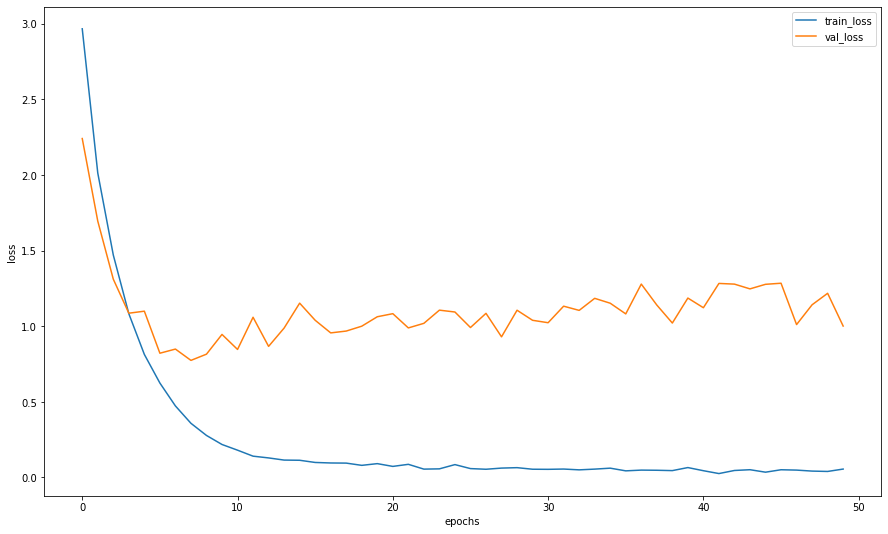

In [49]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

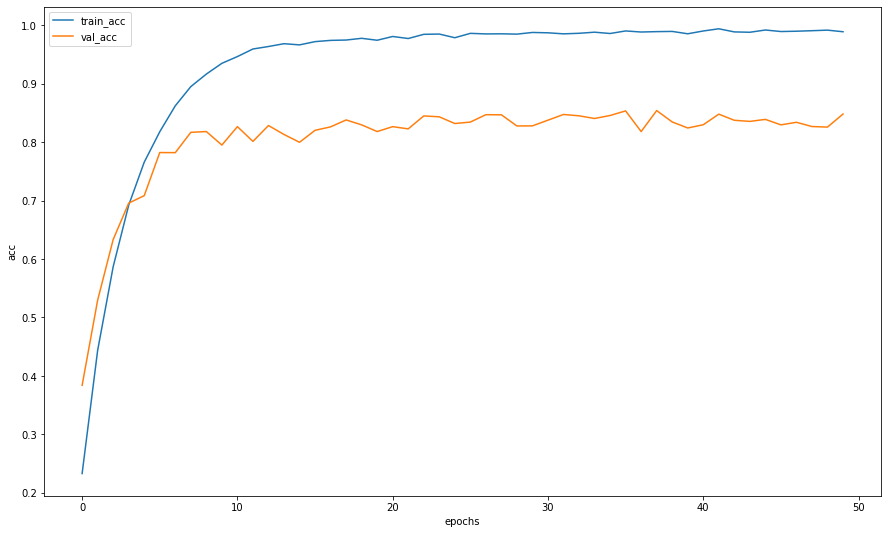

In [50]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [51]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [57]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(cnn, ex_img.unsqueeze(0))

In [59]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(cnn, imgs)

In [60]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [62]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [63]:
preds_class = label_encoder.transform(preds_class)
print(preds_class)

[ 2  0  2  4  4  6  4  4  0 20  2  6  2  0  6  0  0  0  4  4]


In [64]:
print(actual_labels)

[2, 0, 2, 4, 4, 6, 4, 4, 0, 4, 2, 6, 2, 0, 4, 0, 0, 0, 4, 4]


Обратим внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [65]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average='micro')

0.9

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

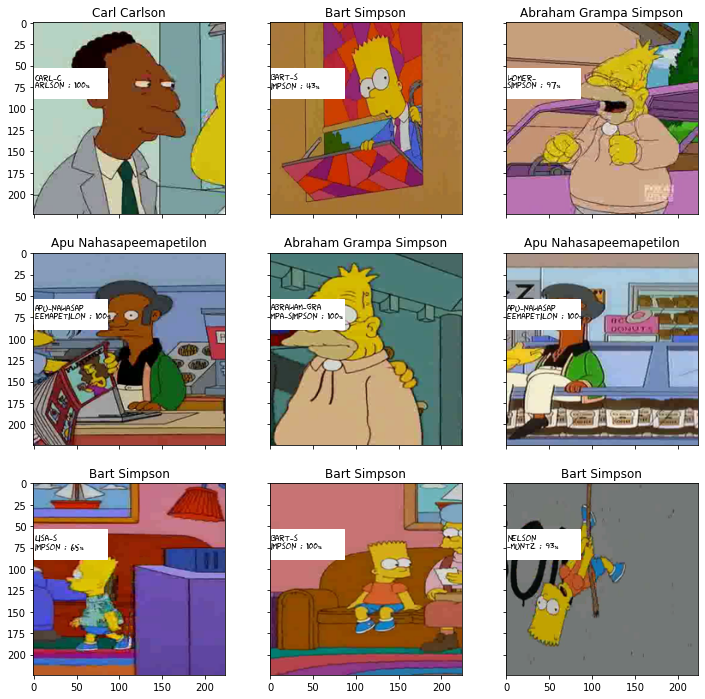

In [67]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [69]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [70]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons_simple_cnn_baseline.csv', index=False)
# файл появится у вас на гугл диске